In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sys,os
import random
from sklearn.model_selection import train_test_split
path = os.getcwd()
path = str(path)+"\cell_images"
print(path)

C:\Users\Win7\Desktop\ML Assignment2\Submission\cell_images


In [2]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16
# percentage of training set to use as validation
test_size = 0.2
valid_size = 0.2
train_size = 0.8

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
    ])

dataset = datasets.ImageFolder(path, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, shuffle = True)

# specify the image classes
classes = ['Parasitized','Uninfected']

# obtain training indices that will be used for validation
num_data = len(dataset)
indices = list(range(num_data))
np.random.seed(3)
np.random.shuffle(indices)
split = int(np.floor(test_size * num_data))
train_idx1, test_idx = indices[split:], indices[:split]

num_train_data = len(dataset) - split
split2 = int(np.floor(valid_size * num_train_data))
train_idx, valid_idx = train_idx1[split2:], train_idx1[:split2]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
print(len(train_idx))
print(len(test_idx))
print(len(valid_idx))

17639
5511
4409


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

(3, 64, 64)


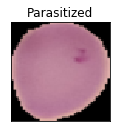

In [5]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(1):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    print(images[idx].shape)
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [6]:
import torch.nn as nn
import torch.nn.functional as F
#35
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 64x64x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)

        # convolutional layer (sees 32x32x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.pool1 = nn.MaxPool2d(3, 3)
        # linear layer (32 *16*16 -> 512)
        self.fc1 = nn.Linear(32 *16*16, 512)
        # linear layer (512 -> 256)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
    
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # flatten image input
        x = x.view(-1,32 *16*16)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer   
        x = self.dropout(x)
        x = self.fc3(x)
        return x
# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.2)
)


In [7]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [8]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss
path = os.getcwd()
path = str(path)+"\malaria_cnn.pt"

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
       # torch.save(model.state_dict(), 'model_augmented.pt')
        
        torch.save(model.state_dict(), path)
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 0.422972 	Validation Loss: 0.100240
Validation loss decreased (inf --> 0.100240).  Saving model ...
Epoch: 2 	Training Loss: 0.378094 	Validation Loss: 0.085060
Validation loss decreased (0.100240 --> 0.085060).  Saving model ...
Epoch: 3 	Training Loss: 0.270851 	Validation Loss: 0.041486
Validation loss decreased (0.085060 --> 0.041486).  Saving model ...
Epoch: 4 	Training Loss: 0.144192 	Validation Loss: 0.031112
Validation loss decreased (0.041486 --> 0.031112).  Saving model ...
Epoch: 5 	Training Loss: 0.122455 	Validation Loss: 0.027272
Validation loss decreased (0.031112 --> 0.027272).  Saving model ...
Epoch: 6 	Training Loss: 0.110323 	Validation Loss: 0.029070
Epoch: 7 	Training Loss: 0.101152 	Validation Loss: 0.024145
Validation loss decreased (0.027272 --> 0.024145).  Saving model ...
Epoch: 8 	Training Loss: 0.094923 	Validation Loss: 0.023810
Validation loss decreased (0.024145 --> 0.023810).  Saving model ...
Epoch: 9 	Training Loss: 0.088949 

KeyboardInterrupt: 

In [9]:
#Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('malaria_cnn.pt'))

In [10]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))


model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
   # for i in range(batch_size):
    for i in range(len(target)):
        label = target.data[i]
        if(pred[i] == label):
           class_correct[label] += 1
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.027088

Test Accuracy of Parasitized: 94% (2611/2756)
Test Accuracy of Uninfected: 96% (2665/2755)

Test Accuracy (Overall): 95% (5276/5511)


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler


import os

In [12]:
#loading the pretrained model 
model = models.vgg16(pretrained = True)

#Freeze the parameters for the model
for param in model.parameters():
    param.requires_grad = False

#view all the layer on VGG16 
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [13]:
import torch.nn.functional as F
class Classifier(nn.Module):
    
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.hidden1 = nn.Linear(25088,4096)
        self.hidden2 = nn.Linear(4096, 4096)
        self.output = nn.Linear(4096, 2)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        
        x = self.dropout(F.relu(self.hidden1(x)))
        x = self.dropout(F.relu(self.hidden2(x)))
        x = self.output(x)
        
        return x

In [14]:
#replace the model's default 
model.classifier = Classifier()

print(model)

#
if train_on_gpu:
    model.cuda()

#define the lost function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr = 0.001, momentum = 0.9)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [15]:
# number of epochs to train the model
n_epochs = 100


path = os.getcwd()
path = str(path)+"\malaria_transfer_learning.pt"

valid_loss_min = np.Inf # track change in validation loss


for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
       # torch.save(model.state_dict(), 'model_augmented.pt')
        torch.save(model.state_dict(),path)
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 0.202403 	Validation Loss: 0.044226
Validation loss decreased (inf --> 0.044226).  Saving model ...
Epoch: 2 	Training Loss: 0.157769 	Validation Loss: 0.033224
Validation loss decreased (0.044226 --> 0.033224).  Saving model ...
Epoch: 3 	Training Loss: 0.144502 	Validation Loss: 0.032636
Validation loss decreased (0.033224 --> 0.032636).  Saving model ...
Epoch: 4 	Training Loss: 0.140496 	Validation Loss: 0.032179
Validation loss decreased (0.032636 --> 0.032179).  Saving model ...
Epoch: 5 	Training Loss: 0.133009 	Validation Loss: 0.029992
Validation loss decreased (0.032179 --> 0.029992).  Saving model ...
Epoch: 6 	Training Loss: 0.128775 	Validation Loss: 0.032305
Epoch: 7 	Training Loss: 0.125876 	Validation Loss: 0.031427
Epoch: 8 	Training Loss: 0.122524 	Validation Loss: 0.030548
Epoch: 9 	Training Loss: 0.119152 	Validation Loss: 0.029482
Validation loss decreased (0.029992 --> 0.029482).  Saving model ...
Epoch: 10 	Training Loss: 0.118722 	Valida

KeyboardInterrupt: 

In [16]:
#Load the Model with the Lowest Validation Loss

model.load_state_dict(torch.load('malaria_transfer_learning.pt'))

In [17]:

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
   # for i in range(batch_size):
    for i in range(len(target)):
        label = target.data[i]
        if(pred[i] == label):
           class_correct[label] += 1
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.034680

Test Accuracy of Parasitized: 93% (2571/2756)
Test Accuracy of Uninfected: 94% (2596/2755)

Test Accuracy (Overall): 93% (5167/5511)
